In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !git clone https://github.com/zangyuchen2008/StopWords '/content/drive/My Drive/app/Stopwords'

In [3]:
!ls '/content/drive/My Drive/app/'

GPUtest.ipynb	      mnist_cnn.py	    Stopwords
keras-mnist-tutorial  senti_classification  Titanic.csv


In [0]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np 
import pandas as pd
import os
import pickle
import jieba
import re 

In [0]:
# path
father_path= r'/content/drive/My Drive/app/senti_classification'
fasttext_w2v_path = os.path.join(father_path, 'w2v_model','cc.zh.300.vec')
trainset_path = os.path.join(father_path, 'data','train','sentiment_analysis_trainingset.csv')
validationset_path = os.path.join(father_path, 'data','validation','sentiment_analysis_validationset.csv')
testset_path = os.path.join(father_path, 'data','test','sentiment_analysis_testa.csv')
stop_word_path = os.path.join(father_path,'data','stop_words.plk')

In [0]:
train = pd.read_csv(trainset_path,sep=',',encoding='utf8')
validation = pd.read_csv(validationset_path,sep=',',encoding='utf8')
test = pd.read_csv(testset_path,sep=',',encoding='utf8')

## Lable encode

In [0]:
bi_encode = LabelBinarizer()
encodes =[]
target_train = train[['dish_taste']]
for index,v in enumerate(target_train.values.T):
    encodes.append(bi_encode.fit_transform(v))
encodes = np.array(encodes)
y_tra = np.concatenate(encodes,axis=1)

target_val = validation[['dish_taste']]
encodes =[]
for index,v in enumerate(target_val.values.T):
    encodes.append(bi_encode.fit_transform(v))
encodes = np.array(encodes)
y_val = np.concatenate(encodes,axis=1)

## tokenlization

In [8]:
list(train)

['id',
 'content',
 'location_traffic_convenience',
 'location_distance_from_business_district',
 'location_easy_to_find',
 'service_wait_time',
 'service_waiters_attitude',
 'service_parking_convenience',
 'service_serving_speed',
 'price_level',
 'price_cost_effective',
 'price_discount',
 'environment_decoration',
 'environment_noise',
 'environment_space',
 'environment_cleaness',
 'dish_portion',
 'dish_taste',
 'dish_look',
 'dish_recommendation',
 'others_overall_experience',
 'others_willing_to_consume_again']

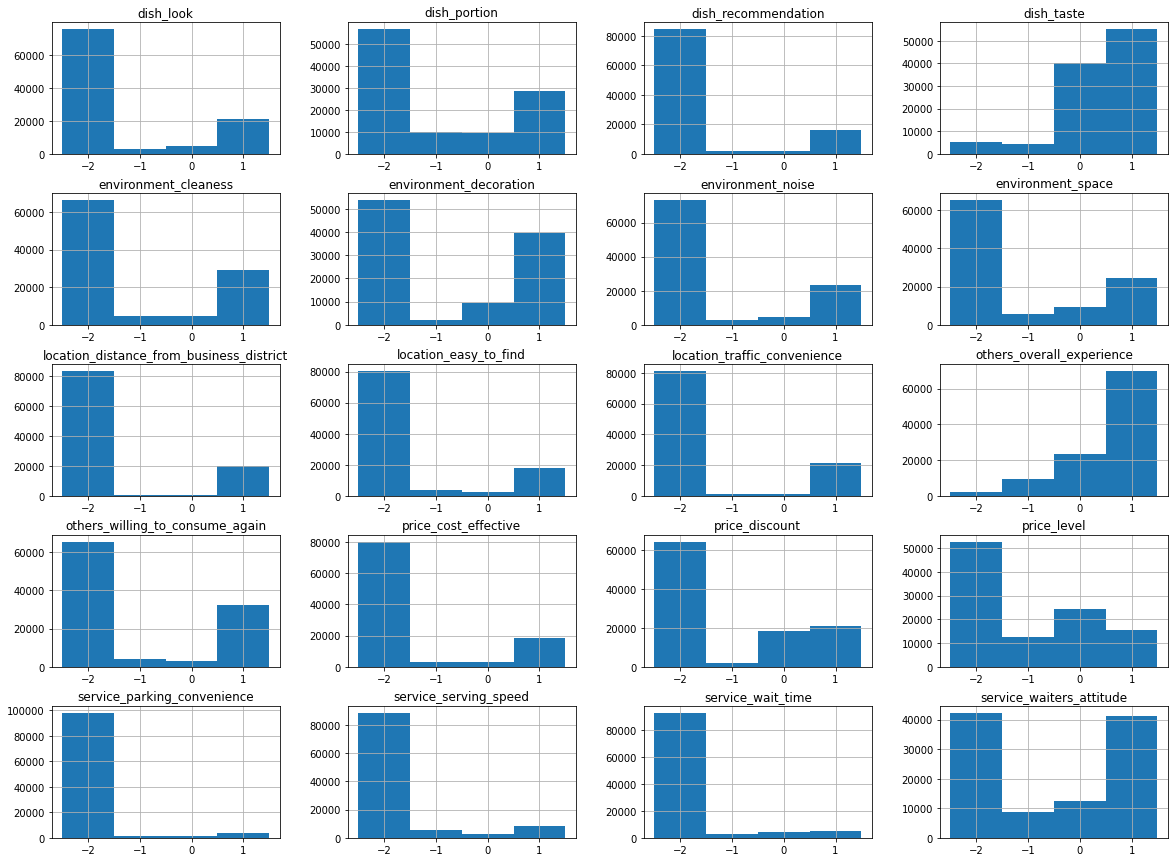

In [34]:
import matplotlib.pyplot as plt
train.iloc[:,2:].hist(bins=[-2.5,-1.5,-0.5,0.5,1.5], figsize=(20,15))
plt.show()

In [0]:
def cut(sen):
    a2=jieba.cut(sen)
    pattern = re.compile('\w+')
    a2=list(filter(pattern.match,a2))
    return a2

In [0]:
# x_tra = train['content'].apply(cut)
# x_val = validation['content'].apply(cut)
# x_te = test['content'].apply(cut)

In [0]:
# pickle.dump([x_tra,x_val,x_te],open(os.path.join(father_path,'cut_tokens.pkl'),'wb'))

In [0]:
# x_tra,x_val,x_te = pickle.load(open(os.path.join(father_path,'cut_tokens.pkl'),'rb'))

In [0]:
# stopwords=pd.read_csv('/content/drive/My Drive/app/Stopwords/stopwords/中文停用词库.txt',encoding='gb2312')
# stopwords= stopwords.values.reshape(745,)

In [0]:
# x_tra = x_tra.apply(lambda x: [w for w in x if w not in stopwords]) 
# x_val = x_val.apply(lambda x: [w for w in x if w not in stopwords]) 
# x_te = x_te.apply(lambda x: [w for w in x if w not in stopwords])

In [0]:
# pickle.dump([x_tra,x_val,x_te],open(os.path.join(father_path,'cut_tokens_wo_stopwords.pkl'),'wb'))

In [0]:
x_tra,x_val,x_te = pickle.load(open(os.path.join(father_path,'cut_tokens_wo_stopwords.pkl'),'rb'))

## sentense embedding

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'
np.random.seed(42)

Using TensorFlow backend.


#### create word index vocabulary

In [0]:
max_features = 30000
maxlen = 400
embed_size = 300
tokenizer = text.Tokenizer(num_words=max_features)#create a tokenizer class with max token limit
tokenizer.fit_on_texts(list(x_tra)+list(x_val)+list(x_te)) # texts: can be a list of list of strings.

#### tranform sentense into index integers

In [0]:
X_train = tokenizer.texts_to_sequences(x_tra)# create index(comming from vocabulary) based integer list to represent sequence
X_valid = tokenizer.texts_to_sequences(x_val)
X_test = tokenizer.texts_to_sequences(x_te)

#### padding to make fixed input length

In [0]:
x_train = sequence.pad_sequences(X_train, maxlen=maxlen) # padding zeros to make 100 length encoded seq list, the default padding is pre padding
x_valid = sequence.pad_sequences(X_valid, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

#### create embedding

In [0]:
# from gensim.models import KeyedVectors

In [0]:
# w2v = pickle.load(open(os.path.join(father_path,'fasttext.plk'),'rb'))

In [0]:
# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
# #     embedding_vector = w2v[word]
#     if word in w2v: embedding_matrix[i] = w2v[word]

In [0]:
# pickle.dump(embedding_matrix,open('embedding_matrix.plk','wb'))

In [0]:
embedding_matrix= pickle.load(open(os.path.join(father_path,'embedding_matrix.plk'),'rb'))

## create model

GRU model

In [0]:
from sklearn.metrics import precision_score

In [0]:
class GRUEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = y_pred>0.5
            pre_score = precision_score(self.y_val, y_pred,average='macro') #,average='weighted'
            print("\n ROC-AUC - epoch: %d - pre_score: %.6f \n" % (epoch+1, pre_score))

In [0]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(10, return_sequences=True))(x) #bidirectional has two inputs if not specified, see keras doc ,units: Positive integer, dimensionality of the output space.
    avg_pool = GlobalAveragePooling1D()(x) # average over features along time steps direction, l
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool]) # concatenate along axis of avg or max_pool in the list by default, input must be list of tensors
    outp = Dense(4, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy',
    #               optimizer='adam',
    #               metrics=['accuracy'])
    return model

cnn plus attention model

In [0]:
import tensorflow as tf 

In [0]:
class ATTEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(tf.keras.callbacks.Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = y_pred > 0.5
            pre_score = precision_score(self.y_val, y_pred,average='macro') #,average='weighted'
            print("\n ROC-AUC - epoch: %d - pre_score: %.6f \n" % (epoch+1, pre_score))

In [0]:
def get_cnn_attention_model():
  # Variable-length int sequences.
  query_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
  # value_input = tf.keras.Input(shape=(None,), dtype='int32')

  # Embedding lookup.
  token_embedding = tf.keras.layers.Embedding(max_features, embed_size)
  # Query embeddings of shape [batch_size, Tq, dimension].
  query_embeddings = token_embedding(query_input)
  # Value embeddings of shape [batch_size, Tv, dimension].
  value_embeddings = token_embedding(query_input)

  # CNN layer.
  cnn_layer = tf.keras.layers.Conv1D(
      filters=100,
      kernel_size=4,
      # Use 'same' padding so outputs have the same shape as inputs.
      padding='same')
  # Query encoding of shape [batch_size, Tq, filters].
  query_seq_encoding = cnn_layer(query_embeddings)
  # Value encoding of shape [batch_size, Tv, filters].
  value_seq_encoding = cnn_layer(value_embeddings)

  # Query-value attention of shape [batch_size, Tq, filters].
  query_value_attention_seq = tf.keras.layers.Attention()(
      [query_seq_encoding, value_seq_encoding])

  # Reduce over the sequence axis to produce encodings of shape
  # [batch_size, filters].
  query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
      query_seq_encoding)
  query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
      query_value_attention_seq)

  # Concatenate query and document encodings to produce a DNN input layer.
  input_layer = tf.keras.layers.Concatenate()(
      [query_encoding, query_value_attention])
  output_layer = tf.keras.layers.Dense(4,activation="sigmoid")(input_layer)
  model = tf.keras.Model(inputs=query_input,outputs=output_layer)
  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return model

## Train

In [74]:
at_model= get_cnn_attention_model()
at_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_7[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 400, 100)     120100      embedding_2[0][0]                
                                                                 embedding_2[1][0]                
____________________________________________________________________________________________

In [75]:
model=get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 400, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 400, 20)      18660       spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [64]:
batch_size = 128
epochs = 2
RocAuc = ATTEvaluation(validation_data=(x_valid, y_val), interval=1)

hist = at_model.fit(x_train, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_val),callbacks=[RocAuc], verbose=2)

Epoch 1/5

 ROC-AUC - epoch: 1 - pre_score: 0.617293 

821/821 - 131s - loss: 0.7670 - accuracy: 0.6470 - val_loss: 0.6833 - val_accuracy: 0.7053
Epoch 2/5

 ROC-AUC - epoch: 2 - pre_score: 0.723726 

821/821 - 129s - loss: 0.5937 - accuracy: 0.7457 - val_loss: 0.7003 - val_accuracy: 0.7046
Epoch 3/5

 ROC-AUC - epoch: 3 - pre_score: 0.715949 

821/821 - 129s - loss: 0.4992 - accuracy: 0.7882 - val_loss: 0.7118 - val_accuracy: 0.7036
Epoch 4/5

 ROC-AUC - epoch: 4 - pre_score: 0.711878 

821/821 - 129s - loss: 0.3992 - accuracy: 0.8356 - val_loss: 0.8307 - val_accuracy: 0.6926
Epoch 5/5

 ROC-AUC - epoch: 5 - pre_score: 0.704992 

821/821 - 130s - loss: 0.3053 - accuracy: 0.8763 - val_loss: 0.9560 - val_accuracy: 0.6835


In [0]:
# batch_size = 64
# epochs = 1
# RocAuc = GRUEvaluation(validation_data=(x_valid, y_val), interval=1)

# hist = model.fit(x_train[:1000,:], y_tra[:1000,:], batch_size=batch_size, epochs=epochs, validation_data=(x_valid[:1000,:], y_val[:1000,:]),callbacks=[RocAuc], verbose=2)

In [82]:
for index in range(1000,1010):
  print(validation['content'][index])
  print('gold:',np.argmax(y_val[index]))
  print('pretict:',np.argmax(at_model.predict(x_valid[index].reshape(1,400))))
  print('**********************************************')

"有幸抽中了一茶一坐22道奢华台宴的体验，老板亲自主持，边吃边介绍，既品尝了美食，又学到了知识，太有收获了
总体感觉就是：食材精挑细选，制作工程精益求精，成品色香味俱全
庆元有机木耳，木耳肉厚，口感好，清淡爽口
宝岛三杯鸡，强力推荐，全部采用鸡腿部位，用油滑过，肉质很嫩，紧致滑嫩，配上九层塔，非常好吃，里边的蒜瓣都很香呢
台湾夜市全家福（五拼），我只吃到了其中的两种，油炸食品，外焦里嫩
阿嫲麻油鸡，汤鲜鸡美，用的是黑芝麻油，很香
浓情熏香子排，炸过的小排很有嚼劲，小排应该是腌制过的，很有味道，好吃
宝岛三杯中卷，
凤梨虾球，虾仁裹了面糊炸过，辅以菠萝，特别配制了添加了百香果的汁液，占着吃，别有一番滋味，吃后，唇齿留香

台湾海捞褔仔鱼，台湾特产的福仔鱼，肉厚刺少，鲜美多汁，没有一点儿鱼腥味
麻辣牛蛙，牛蛙滑嫩，豆腐也很入味
客家鱼香豆腐，偏甜口
客家菜脯蛋，鸡蛋里有肉哟，配上洋葱，很香，但有的油腻
眷村牛筋腩萝卜煲（红烧），强力推荐，里边的每一样食材都好好吃啊，萝卜、牛肉、牛筋，都很入味，酥软而不烂
菌菇空心菜，菌菇酱有点儿辣味，还是很下饭的
台式海鲜酸辣汤，不错的味道，用料十足
四神汤，强力推荐，薏仁米、莲子、猪肚等等，汤特别鲜美，大爱啊
卤肉饭，很美味，有两种浇头，一种是肉燥，一种是肉条，味道超好吃，老板说他家绝对是最正宗的卤肉饭，确实比我在其他地方吃到的要好吃很多，不光料好，就是单吃米饭，也很香，他家的米饭是寒香米饭
木瓜牛奶，没有添加剂，就是纯粹的木瓜加牛奶，美味很赞

年轮蛋糕，我喜欢里边的部分
"
gold: 3
pretict: 3
**********************************************
"连续去吃了两天，因为味道蛮不错的。就是门面有点小，进去太挤了，选菜的地方很靠座位，所以进去坐的时候不方便，我抱着小孩走也走不进去，前面挡着个人在选菜，动都不动一个，无语啊。其实服务生也蛮多的，就是都顾着干活。每次去乌鸡卷，鸭血，都是必点的菜品，超级好吃，偶尔也点牛肚味道也蛮好的。点点的素菜也要点很多，超级好吃。每次都是竖着进去恨不得躺着出来，好吃的。什么都好，就是服务很需要提高。菜品本身蛮不错的。"
gold: 3
pretict: 3
**********************************************